In [26]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage import draw
from skimage.filters import gaussian
from skimage.segmentation import active_contour
import glob
import skimage.io as skio
import cv2
import pandas as pd
from scipy.stats import skew, kurtosis
from random import randint

### Geração do novo dataset com imagens segmentadas

In [2]:
def segment_image(filename, label, final_contour=None):
    source_img = skio.imread(filename)
    img = rgb2gray(source_img)
    if not final_contour:
        initial_contour = np.array([
            [int(img.shape[0] * 0.1), int(img.shape[1] * 0.1)],
            [int(img.shape[0] * 1), int(img.shape[1] * 0.1)],
            [int(img.shape[0] * 1), int(img.shape[1] * 1)],
            [int(img.shape[0] * 0.1), int(img.shape[1] * 1)],
            [int(img.shape[0] * 0.1), int(img.shape[1] * 0.1)],
        ])

        num_points = 200
        x_interp = np.linspace(initial_contour[0, 0], initial_contour[1, 0], num_points)
        y_interp = np.linspace(initial_contour[0, 1], initial_contour[1, 1], num_points)
        points_between_01 = np.column_stack((x_interp, y_interp))

        x_interp = np.linspace(initial_contour[1, 0], initial_contour[2, 0], num_points)
        y_interp = np.linspace(initial_contour[1, 1], initial_contour[2, 1], num_points)
        points_between_12 = np.column_stack((x_interp, y_interp))

        x_interp = np.linspace(initial_contour[2, 0], initial_contour[3, 0], num_points)
        y_interp = np.linspace(initial_contour[2, 1], initial_contour[3, 1], num_points)
        points_between_23 = np.column_stack((x_interp, y_interp))

        x_interp = np.linspace(initial_contour[3, 0], initial_contour[4, 0], num_points)
        y_interp = np.linspace(initial_contour[3, 1], initial_contour[4, 1], num_points)
        points_between_34 = np.column_stack((x_interp, y_interp))

        # Juntar todos os pontos
        final_contour = np.vstack([initial_contour, points_between_01, points_between_12, points_between_23, points_between_34])

    snake2 = active_contour(gaussian(img, 3, preserve_range=False), final_contour, alpha=0.015, beta=10, gamma=0.001)

    new_image = np.zeros_like(source_img)
    rr, cc = draw.polygon(snake2[:, 0], snake2[:, 1])
    new_image[rr, cc] = 255
    plt.imsave(f"dataset/{label}/{filename.split('/')[-1]}", new_image)    


path = "../cars/img/*.jpg"

features = []

for index, filename in enumerate(glob.glob(path)):
    try:
        segment_image(filename, "processed")
    except:
        pass
    print(f"{index+1} imagens processadas")
    



1 imagens processadas
2 imagens processadas
3 imagens processadas
4 imagens processadas
5 imagens processadas
6 imagens processadas
7 imagens processadas
8 imagens processadas
9 imagens processadas
10 imagens processadas
11 imagens processadas
12 imagens processadas
13 imagens processadas
14 imagens processadas
15 imagens processadas
16 imagens processadas
17 imagens processadas
18 imagens processadas
19 imagens processadas
20 imagens processadas


# Visualização

In [ ]:
filenames = glob.glob(f"../cars/masks/*.png")

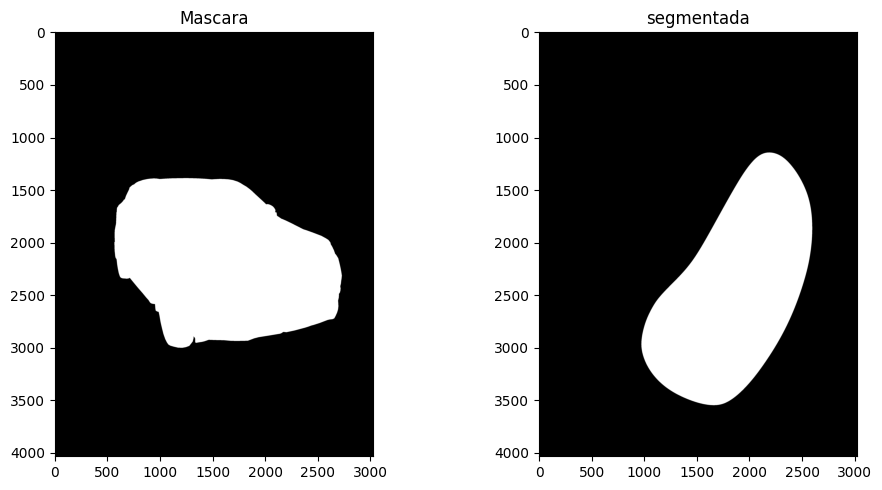

<Figure size 640x480 with 0 Axes>

In [31]:
filenames = glob.glob(f"../cars/masks/*.png")
filename = filenames[randint(0, len(filenames))]

mask = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_RGB2GRAY)
x = (mask != 255)
file = filename.split("/")[-1].replace("png", "jpg")

segmented_image = cv2.cvtColor(cv2.imread(f"dataset/processed/{file}"), cv2.COLOR_RGB2GRAY)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Desenhe a primeira imagem no primeiro subplot
axs[0].imshow(x, cmap='gray')
axs[0].set_title('Mascara')

# Desenhe a segunda imagem no segundo subplot
axs[1].imshow(segmented_image, cmap='gray')
axs[1].set_title('segmentada')

# Ajuste o layout para evitar sobreposição de rótulos
plt.tight_layout()

# Exiba as imagens
plt.show()
plt.savefig("compare_img.png")

# Métricas

In [32]:
def calc_iou():    
    results_intersection = []
    for filename in filenames:
        mask = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_RGB2GRAY)
        x = (mask != 255)
        file = filename.split("/")[-1].replace("png", "jpg")
        
        segmented_image = cv2.cvtColor(cv2.imread(f"dataset/processed/{file}"), cv2.COLOR_RGB2GRAY)        
        intersection = np.sum(x & segmented_image)
        
        union = np.sum(x | segmented_image)        

        results_intersection.append((intersection/union))        


    print("intersection", np.mean(results_intersection))    

calc_iou()

intersection 0.0028117539434806146


In [24]:
def calc_pixel():
    results_pixels = []
    for filename in filenames:
        mask = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_RGB2GRAY)
        x = (mask != 255)

        file = filename.split("/")[-1].replace("png", "jpg")
        
        segmented_image = cv2.cvtColor(cv2.imread(f"dataset/processed/{file}"), cv2.COLOR_RGB2GRAY)

        accuracy = np.sum(x == segmented_image) / mask.size
        
        
        results_pixels.append(accuracy)        

    print("pixels", np.mean(results_pixels))   

calc_pixel()

pixels 0.687766441855289


# Resultados

Utilizando o método de contorno ativo, snake, para segmentar o carro, obtivemos resultados inferiores ao métodos anteriores ao utilizar a métrica de intersecção, no entanto ao utilizar o cálculo de pixels, o resultado foi superior.

A maior dificuldade desse método é a definição do contorno inicial. Haja visto que, o contorno inicial deve ser próximo ao objeto de interesse. Dessa forma, faz sentido utilizar em conjunto com outras técnicas para geração desse contorno. Nesse Projeto especificamente, buscamos utilizar uma região de grande abrangência dentro da imagem. Assumindo que o objeto de interesse ocupa o maior espaço dentro da entrada.

### Experimentos anteriores

Utilizando meanshift, otsu, niblack e kmeans o melhor resultado na métrica de intersecção foi 57.9% com niblack e na métrica de calculo de pixels o k-means obteve 31.4%.

### Experimentos Atuais

Com a técnica de contorno ativo, mesmo colocando o contorno inicial de forma genérica e aplicando apenas um filtro de suavização. Obtivemos na métrica de intersecção um resultado muito ruim. Porém ao utilizar a métrica de pixels, o resultado foi bastante superior, alcançando 68.7% de acurácia.

Os parâmetros utilizados foram:
 - Alpha (α) = 0.15:
    - Descrição: Parâmetro que controla o comprimento da serpente (contorno ativo). Valores mais altos de alpha fazem com que a serpente se contraia mais rapidamente.
    - Influência: Afeta a flexibilidade da serpente. Valores mais altos geralmente levam a contornos mais suaves, mas podem ter impacto na capacidade da serpente de se adaptar a detalhes finos.

 - Beta (β) = 10:

    - Descrição: Parâmetro que controla a suavidade da serpente.
    - Influência: Valores mais altos de beta resultam em contornos mais suaves, pois minimizam a energia associada à curvatura da serpente.
 - Gamma (γ) = 0.001:
    - Descrição: Parâmetro que controla o passo de tempo explícito no método de otimização.
    - Influência: Afeta a taxa de convergência do algoritmo. Valores adequados de gamma são importantes para garantir que a serpente se ajuste corretamente à imagem, evitando oscilações indesejadas.